# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

d:\mamba\envs\default\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Determine if an nvidia GPU is available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [3]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [4]:
resnet = InceptionResnetV1(pretrained='casia-webface').eval().to(device)

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [8]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('../hard_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [9]:
dataset.idx_to_class

{0: 'n000854', 1: 'n003354', 2: 'n003357', 3: 'n009117'}

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [10]:
aligned = []
names = []
# only get one image per person
# people = set()
for x, y in loader:
    person = dataset.idx_to_class[y]
    # if person in people:
    #     continue
    # people.add(person)
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        #print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(person)
    else:
        # print path of images that are not detected
        print(f"person not detection {person}")

person not detection n000854
person not detection n000854
person not detection n000854
person not detection n000854
person not detection n000854
person not detection n000854


In [11]:
# split up aligned images into batches
aligned = torch.stack(aligned)
aligned = torch.split(aligned, 32)
# pass each batch through resnet
embeddings = []
for batch in aligned:
    embeddings.extend(resnet(batch.to(device)).detach().cpu())

In [15]:
embeddings.shape

(1458, 512)

In [55]:
# convert embeddings to numpy
# embeddings= torch.stack(embeddings).numpy()
# names = np.array(names)
# save embeddings and names
np.save('embeddings_hard.npy', embeddings)
np.save('names_hard.npy', names)

#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [82]:
import numpy as np
import faiss
from sklearn.metrics import roc_curve, auc

class FacialVerifier:
    def __init__(self, known_embeddings):
        self.known_embeddings = np.array(known_embeddings).astype('float32')
        self.index = faiss.IndexFlatL2(self.known_embeddings.shape[1])
        self.index.add(self.known_embeddings)

    def verify(self, unknown_embeddings, true_labels, name, thresholds):
        distances = self._compute_distances(unknown_embeddings)
        true_labels = np.array([1 if label == name else 0 for label in true_labels])

        fpr_list = []
        tpr_list = []
        accuracies = []

        for threshold in thresholds:
            predicted_labels = np.array(distances) <= threshold

            tp = np.sum((predicted_labels == 1) & (true_labels == 1))
            fp = np.sum((predicted_labels == 1) & (true_labels == 0))
            tn = np.sum((predicted_labels == 0) & (true_labels == 0))
            fn = np.sum((predicted_labels == 0) & (true_labels == 1))

            fpr = fp / (fp + tn)
            tpr = tp / (tp + fn)

            fpr_list.append(fpr)
            tpr_list.append(tpr)

            accuracy = (tp + tn) / len(unknown_embeddings)
            accuracies.append(accuracy)
            # print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")

        return fpr_list, tpr_list, accuracies

    # def _compute_distances(self, unknown_embeddings):
    #     unknown_embeddings = np.array(unknown_embeddings).astype('float32')
    #     distances, _ = self.index.search(unknown_embeddings, 1)
    #     return distances.flatten()
    # takes weighted average distance between k nearest neighbors
    def _compute_distances(self, unknown_embeddings, k=5):
        k = min(k, len(self.known_embeddings))
        unknown_embeddings = np.array(unknown_embeddings).astype('float32')
        distances, indices = self.index.search(unknown_embeddings, k)
        weights = 1.0 / (distances + 1e-6)  # Add a small constant to avoid division by zero
        weighted_distances = np.sum(distances * weights, axis=1) / np.sum(weights, axis=1)
        return weighted_distances

    def _compute_accuracy(self, distances, true_labels, threshold):
        predicted_labels = np.array(distances) <= threshold
        accuracy = np.mean(predicted_labels == true_labels)
        return accuracy

    def compute_auc(self, fpr_list, tpr_list):
        auc_value = np.trapz(tpr_list, fpr_list)
        return auc_value

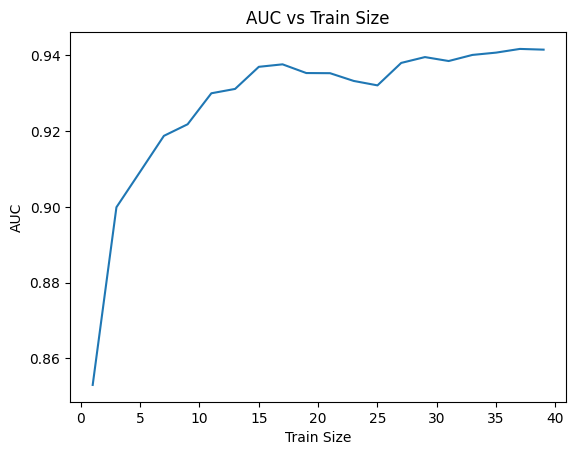

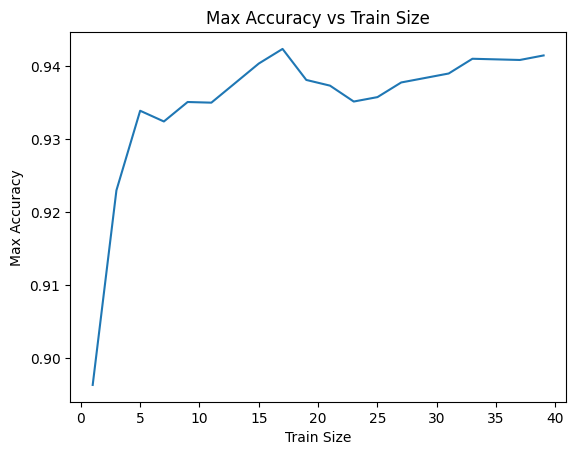

In [86]:

from matplotlib import pyplot as plt
def get_auc_for_train_size(embeddings, names, celeb_name, train_size):
    celeb_embedding = embeddings[names == celeb_name]
    known_embeddings = celeb_embedding[:train_size]
    known_indices = np.where(np.isin(names, celeb_name))[0][:train_size]
    # Create a boolean mask for the remaining indices
    mask = np.ones(len(embeddings), dtype=bool)
    mask[known_indices] = False
    # Use the mask to filter test_embeddings and test_names
    test_embeddings = embeddings[mask]
    test_names = names[mask]
    
    verifier = FacialVerifier(known_embeddings=known_embeddings)
    thresholds = np.arange(0, 2, 0.05)
    fpr_list, tpr_list, accuracies = verifier.verify(test_embeddings, true_labels=test_names, name=celeb_name, thresholds=thresholds)
    max_accuracy = max(accuracies)
    auc = verifier.compute_auc(fpr_list, tpr_list)
    return auc, max_accuracy

def plot_auc_train_size(embeddings, names, celeb_name):
    aucs = []
    max_accuracies = []
    train_sizes = list(range(1, 40, 2))
    for train_size in train_sizes:
        auc, max_accuracy = get_auc_for_train_size(embeddings, names, celeb_name, train_size)
        aucs.append(auc)
        max_accuracies.append(max_accuracy)
    plt.plot(train_sizes, aucs)
    plt.xlabel('Train Size')
    plt.ylabel('AUC')
    plt.title('AUC vs Train Size')
    plt.show()
    # plot max accuracies
    plt.plot(train_sizes, max_accuracies)
    plt.xlabel('Train Size')
    plt.ylabel('Max Accuracy')
    plt.title('Max Accuracy vs Train Size')
    plt.show()
    return aucs, train_sizes

# test_names = np.array(['n009117', 'n003357'])
# mask = np.isin(names, test_names)
# test_embeddings = embeddings[mask]
# test_names = names[mask]
aucs, train_sizes = plot_auc_train_size(embeddings, names, 'n003357') # n000854 n003357 n009117 

In [87]:
aucs

[0.852988120943604,
 0.8998868459161093,
 0.9092881368778069,
 0.9187358808743517,
 0.9217967542751621,
 0.929976481686082,
 0.931125355661612,
 0.9369607154808697,
 0.937615315940879,
 0.9353175052823122,
 0.9352791196092527,
 0.9332303920572678,
 0.9320633435970258,
 0.9379908455793784,
 0.9395294207454598,
 0.9384905501948737,
 0.9400996281583609,
 0.9407094726805699,
 0.9416849054572856,
 0.9414937504071103]